# plot intensity variance vs nuclear size


In [31]:
import napari
import torch
from skimage.measure import regionprops_table, regionprops
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import cellpose
from cellpose import models
import edt
import glob
import os
import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
import gc
import seaborn as sns
from sklearn.mixture import GaussianMixture
from bioio import BioImage
import bioio_nd2
import bioio_tifffile
from bioio.writers import OmeTiffWriter


anisotropy = (3,1,1) # Relative scale of (Z,X,Y) axes

nucChannel = 0 # red emerin rings
spotChannel = 1 # green spots

# in lucien's original scripts:
# channel 0 is green spots
# channel 1 is red emerin

In [32]:
# on server
raw_input_path = '/mnt/external.data/MeisterLab/Dario/Imaging/DPY27/1268/20240915_3d/'
denoised_input_path = raw_input_path+'N2V_1268RG_1273RG/denoised/'
output_path = '/mnt/external.data/MeisterLab/jsemple/lhinder/segmentation_Dario/DPY27/'

if not os.path.exists(output_path+"/plots"):
    os.makedirs(output_path+"/plots")

df=pd.read_csv(output_path+"nuclei_analysis_v001.csv")
df

dist=pd.read_pickle(output_path+"dist_analysis_v001.pkl")
dist

,label,bb_dimZ,bb_dimY,bb_dimX,centroid_z,centroid_y,centroid_x,major_axis_length,solidity,mean,...,std,sum,variance,max,min,volume,id,intensity_dist_nuclei,intensity_dist_spots,intensity_dist
0,1,3,332,196,10.237467,450.775726,209.588391,764.512529,0.087499,121.188654,...,9.385192,91861,88.081824,148,99,758,DPY27_3d_20240915_1268_E_bean_15um,[],[],[]
0,2,13,51,48,17.092244,602.730192,235.823937,48.632410,0.728521,213.400834,...,61.361131,2558676,3765.188456,793,105,11990,DPY27_3d_20240915_1268_E_bean_15um,"[134.06474820143885, 140.66141732283464, 144.1...","[202.6043165467626, 217.77165354330708, 231.94...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
0,3,24,48,58,23.818743,465.149410,405.504229,59.554474,0.738189,227.012229,...,143.260306,5959071,20523.515241,1047,99,26250,DPY27_3d_20240915_1268_E_bean_15um,"[136.09174311926606, 135.79, 137.9076923076923...","[188.52293577981652, 201.32, 206.5692307692307...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
0,4,13,47,42,17.885833,526.404655,261.189650,47.890527,0.919311,208.377154,...,116.236053,3205049,13510.819916,854,99,15381,DPY27_3d_20240915_1268_E_bean_15um,"[140.14110429447854, 143.66883116883116, 147.5...","[154.62576687116564, 148.98701298701297, 152.5...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
0,5,10,47,50,16.749367,537.583875,332.809957,50.926443,0.926797,179.198181,...,93.185448,2620415,8683.527708,720,94,14623,DPY27_3d_20240915_1268_E_bean_15um,"[131.55307262569832, 138.69398907103826, 144.7...","[127.77094972067039, 130.05464480874318, 134.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,176,1,51,38,73.000000,469.446735,300.224055,57.590836,inf,114.686598,...,10.886578,166869,118.517587,178,93,1455,DPY27_3d_20240915_1268_E_mid_15um_08,"[107.13333333333334, 108.28481012658227, 106.0...","[114.71333333333334, 116.55696202531645, 117.1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
0,177,3,50,46,73.961521,519.764720,547.305285,50.847402,0.832176,122.205610,...,14.647588,527195,214.551837,200,94,4314,DPY27_3d_20240915_1268_E_mid_15um_08,"[107.68518518518519, 107.77852348993288, 108.7...","[126.17283950617283, 124.60402684563758, 122.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
0,178,2,47,45,74.548074,82.651857,356.528636,50.134214,0.929655,123.495314,...,14.709712,355790,216.375629,184,93,2881,DPY27_3d_20240915_1268_E_mid_15um_08,"[107.45238095238095, 108.55367231638418, 106.8...","[114.17857142857143, 116.12429378531074, 117.2...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
0,179,2,45,47,74.516835,229.001347,541.797306,51.816379,0.942857,117.805724,...,9.175559,349883,84.190876,154,92,2970,DPY27_3d_20240915_1268_E_mid_15um_08,"[108.29239766081871, 108.7202380952381, 107.73...","[117.21052631578948, 118.77380952380952, 118.6...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


## Plot histograms of individual data columns

This might help in finding variables to filter on.

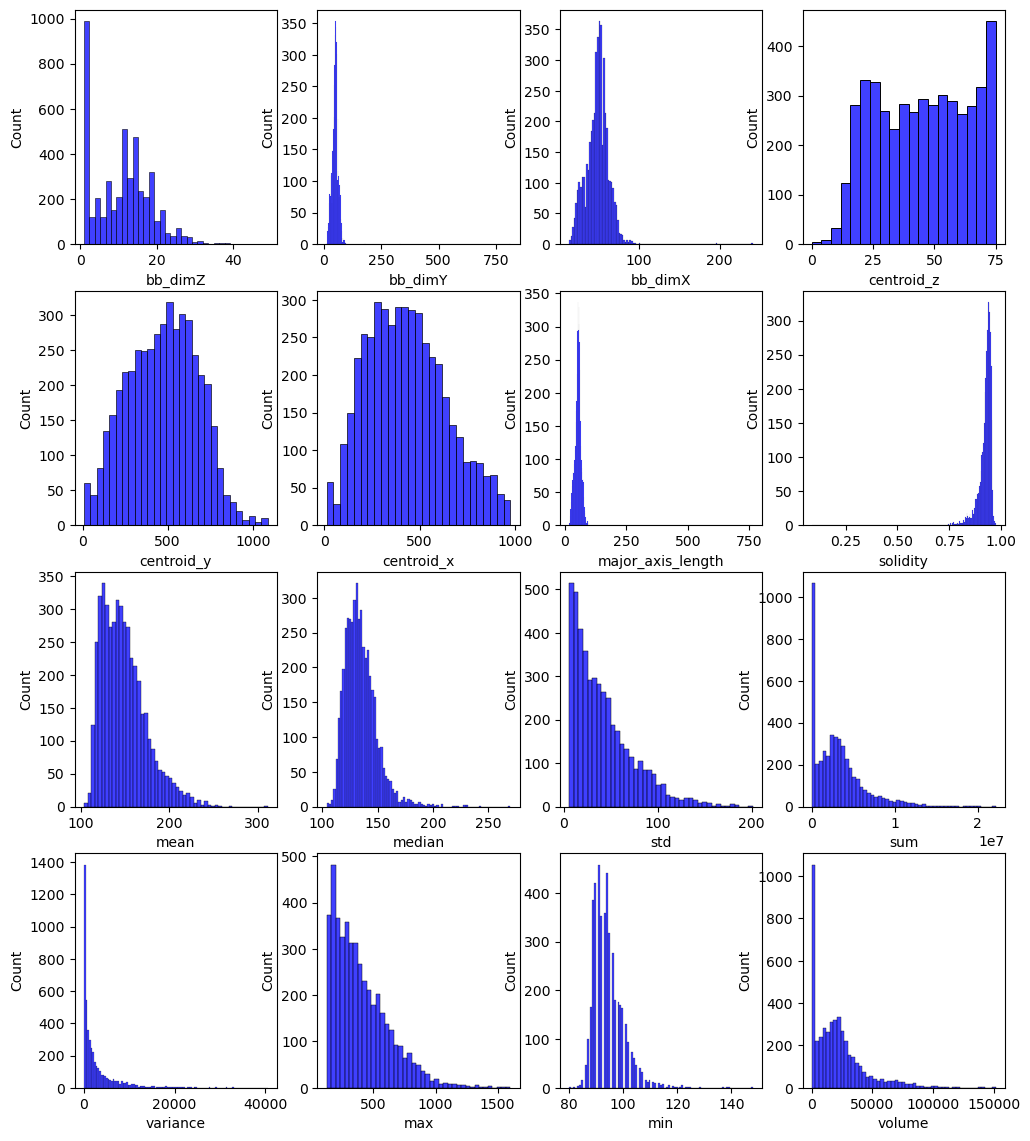

In [35]:
fig, axs = plt.subplots(4, 4, figsize=(12, 14))
sns.histplot(data=df, x="bb_dimZ", color='blue', ax=axs[0,0])
sns.histplot(data=df, x="bb_dimY", color='blue', ax=axs[0,1])
sns.histplot(data=df, x="bb_dimX",  color='blue', ax=axs[0,2])
sns.histplot(data=df, x="centroid_z",  color='blue', ax=axs[0,3])
sns.histplot(data=df, x="centroid_y",  color='blue', ax=axs[1,0])
sns.histplot(data=df, x="centroid_x",  color='blue', ax=axs[1,1])
sns.histplot(data=df, x="major_axis_length",  color='blue', ax=axs[1,2])
sns.histplot(data=df, x="solidity",  color='blue', ax=axs[1,3])
sns.histplot(data=df, x="mean",  color='blue', ax=axs[2,0])
sns.histplot(data=df, x="median",  color='blue', ax=axs[2,1])
sns.histplot(data=df, x="std",  color='blue', ax=axs[2,2])
sns.histplot(data=df, x="sum",  color='blue', ax=axs[2,3])
sns.histplot(data=df, x="variance",  color='blue', ax=axs[3,0])
sns.histplot(data=df, x="max", color='blue', ax=axs[3,1])
sns.histplot(data=df, x="min",  color='blue', ax=axs[3,2])
sns.histplot(data=df, x="volume",  color='blue', ax=axs[3,3])
plt.show()

/tmp/ipykernel_2028488/437432233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt['cv']= filt['std']/filt['mean']


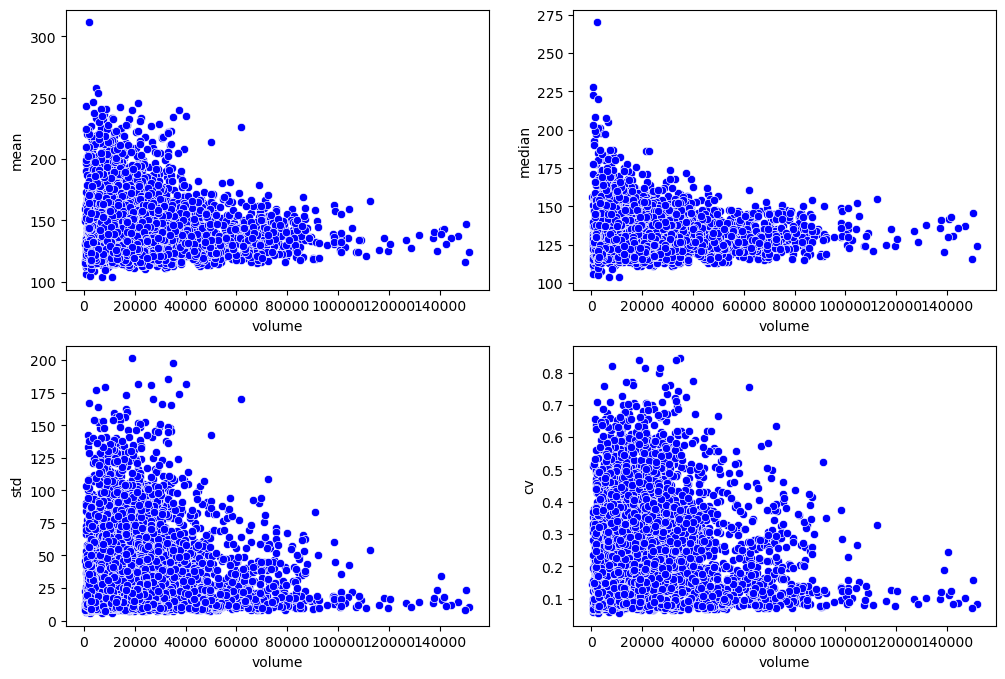

In [48]:
filt=df[(df.solidity>0.8) & (df.solidity<1.0) ]
filt['cv']= filt['std']/filt['mean']
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.scatterplot(data=filt, x="volume", y="mean", color='blue', ax=axs[0,0])
sns.scatterplot(data=filt, x="volume", y="median", color='blue', ax=axs[0,1])
sns.scatterplot(data=filt, x="volume", y="std", color='blue', ax=axs[1,0])
sns.scatterplot(data=filt, x="volume", y="cv", color='blue', ax=axs[1,1])
plt.show()

In [49]:
df.shape


(4634, 26)

In [50]:
filt.shape

(3793, 26)

In [ ]:

plt.figure(figsize = (30,5),dpi = 300)
#plt.ylim((0,0.25e5))
violin_plot = sns.violinplot(data=df_filt, x="group", y="mass", inner=None)
for item in violin_plot.get_xticklabels():
    item.set_rotation(90)
violin_plot.tick_params(labelsize=10)
plt.title('Mean nuclear volume (in px^3) per group')